In [31]:
# Data Science Corpus - Exploratory Data Analysis
# Working with JSONL files for semantic search

import polars as pl
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import re
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

# Download stopwords if not already downloaded
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print("Libraries imported successfully!")
print(f"Polars version: {pl.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Polars version: 1.14.0
NumPy version: 1.26.4


In [23]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [ ]:
# Load JSONL data

def load_jsonl(file_path):
    """Load JSONL file into a list of dictionaries"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

# Load the clean corpus data
print("Loading JSONL data...")
corpus_data = load_jsonl('data/ds_corpus_clean.jsonl')
print(f"Loaded {len(corpus_data)} records")

# Convert to DataFrame
df = pl.DataFrame(corpus_data)


Loading JSONL data...
Loaded 6259 records


In [6]:
df = pl.DataFrame(corpus_data)
df.head()

id,title,text,url
str,str,str,str
"""Artificial_intelligence_0""","""Artificial intelligence""","""Artificial intelligence (AI) i…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_1""","""Artificial intelligence""","""High-profile applications of A…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_2""","""Artificial intelligence""","""Various subfields of AI resear…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_3""","""Artificial intelligence""","""Artificial intelligence was fo…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_4""","""Artificial intelligence""","""The general problem of simulat…","""https://en.wikipedia.org/wiki/…"


In [7]:
# Print the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# Display the schema
print("\nDataframe Schema:")
print(df.schema)

# Check for missing values
print("\nMissing Values:")
print(df.null_count())


Shape of the DataFrame: (6259, 4)

Dataframe Schema:
Schema([('id', String), ('title', String), ('text', String), ('url', String)])

Missing Values:
shape: (1, 4)
┌─────┬───────┬──────┬─────┐
│ id  ┆ title ┆ text ┆ url │
│ --- ┆ ---   ┆ ---  ┆ --- │
│ u32 ┆ u32   ┆ u32  ┆ u32 │
╞═════╪═══════╪══════╪═════╡
│ 0   ┆ 0     ┆ 0    ┆ 0   │
└─────┴───────┴──────┴─────┘


In [10]:
# Examine Document Lengths
df_with_stats = df.with_columns(
    pl.col("text").str.len().alias("text_length")
)

# Utilize GPU for speed
result = df_with_stats.collect(engine=pl.GPUEngine(device=1))

# Shows stats for the text length column
print("\nText Length Statistics:")
print(result.select("text_length").describe())


Text Length Statistics:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ text_length │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 6259.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 359.324333  │
│ std        ┆ 235.833404  │
│ min        ┆ 125.0       │
│ 25%        ┆ 184.0       │
│ 50%        ┆ 287.0       │
│ 75%        ┆ 459.0       │
│ max        ┆ 2538.0      │
└────────────┴─────────────┘


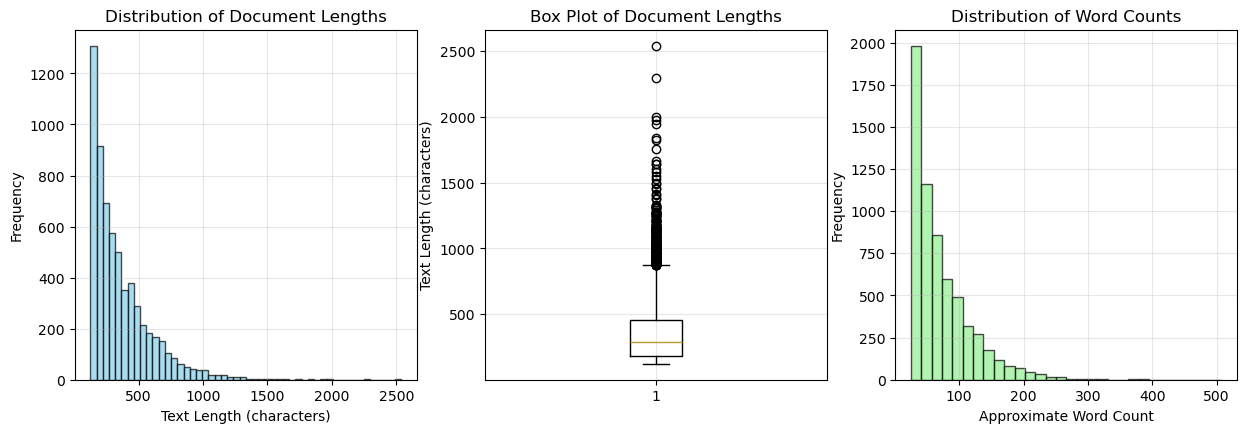

In [27]:
# Subplot 1: Histogram of text lengths
plt.subplot(2, 3, 1)
plt.hist(df_with_stats['text_length'].to_list(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.grid(True, alpha=0.3)


# Subplot 3: Word count distribution (approximate)
word_counts_per_doc = df_with_stats.with_columns(
    (pl.col("text_length") / 5).round().alias("approx_word_count")  # Rough estimate: 5 chars per word
)
plt.subplot(2, 3, 3)
plt.hist(word_counts_per_doc['approx_word_count'].to_list(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Approximate Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(True, alpha=0.3)

# Subplot 2: Box plot of text lengths
plt.subplot(2, 3, 2)
plt.boxplot(df_with_stats['text_length'].to_list(), vert=True)
plt.ylabel('Text Length (characters)')
plt.title('Box Plot of Document Lengths')
plt.grid(True, alpha=0.3)

In [19]:
# Calculate the frequency of each word in the 'text' column (excluding stop words)

# Create a list of stop words for filtering
stop_words_list = list(stop_words)

word_counts = ( 
    df.lazy()
    .select(pl.col("text").str.to_lowercase().str.split(" ").alias("words")
    )
    .explode("words")
    .filter(pl.col("words") != "")
    .filter(~pl.col("words").is_in(stop_words_list))  # Filter out stop words
    .filter(pl.col("words").str.len_chars() > 2)  # Filter out very short words
    .group_by("words")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
    .limit(20)
    .collect()
)

print("Top 20 words by frequency:")
print(word_counts)



Top 20 words by frequency:
shape: (20, 2)
┌────────────────┬───────┐
│ words          ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ data           ┆ 2489  │
│ used           ┆ 1147  │
│ model          ┆ 1040  │
│ one            ┆ 883   │
│ learning       ┆ 826   │
│ …              ┆ …     │
│ information    ┆ 470   │
│ {\displaystyle ┆ 464   │
│ models         ┆ 464   │
│ training       ┆ 462   │
│ function       ┆ 436   │
└────────────────┴───────┘


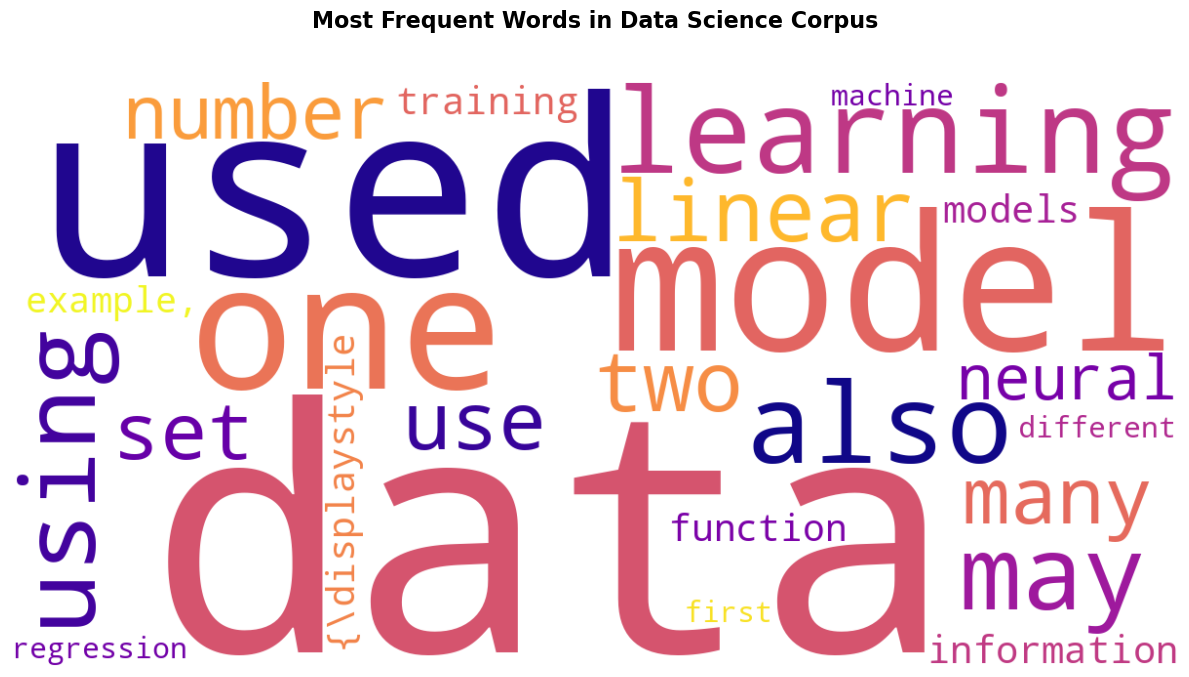

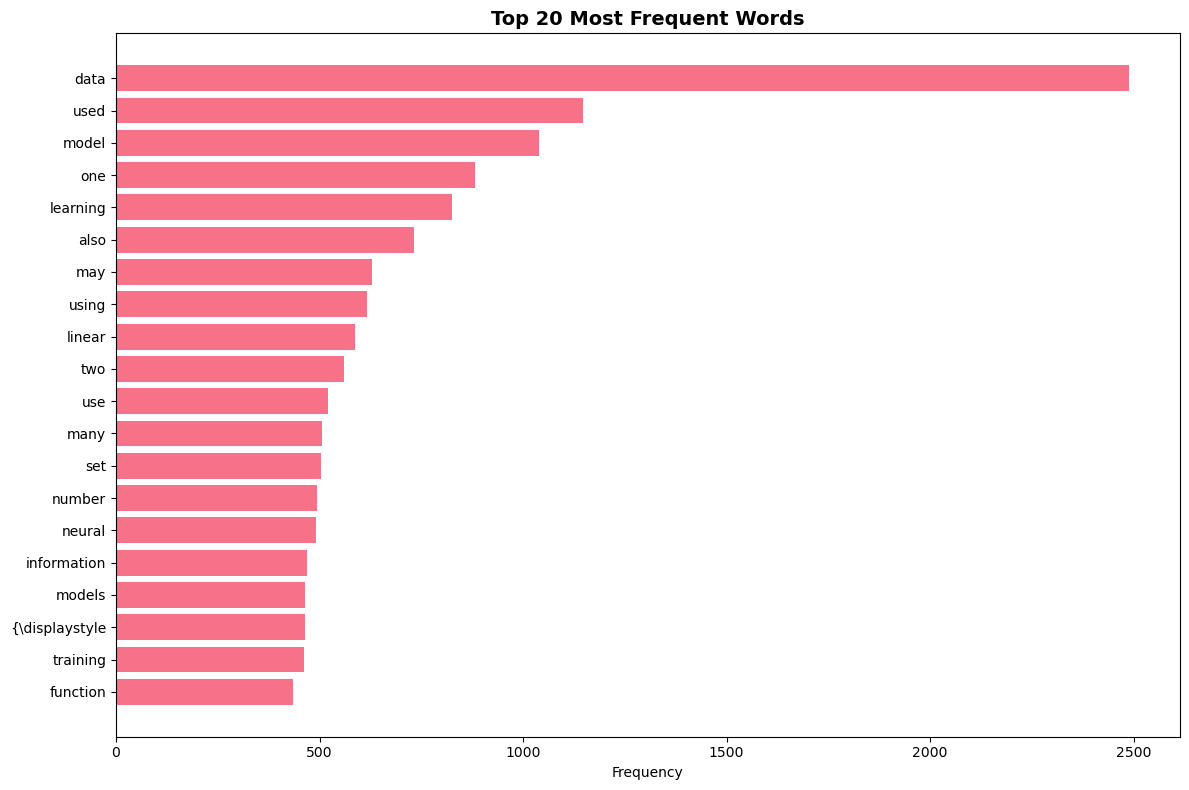

In [ ]:
# Convert the word counts to a dictionary for WordCloud
word_freq_dict = dict(zip(word_counts['words'].to_list(), word_counts['count'].to_list()))

# Create the word cloud
wordcloud = WordCloud(
    width=1200, 
    height=600, 
    background_color='white',
    colormap='plasma',  
    max_words=50,  # Show top 50 words
    relative_scaling=0.5,
    random_state=42
).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Data Science Corpus\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Also show the top 20 words as a bar chart for comparison
top_20 = word_counts.head(20)
plt.barh(range(len(top_20)), top_20['count'].to_list())
plt.yticks(range(len(top_20)), top_20['words'].to_list())
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Show highest frequency at top
plt.tight_layout()
plt.show()


In [32]:
# We need to convert the Polars Series to a list for scikit-learn
corpus = df['text'].to_list()

# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range, n=15):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get and print top 15 bigrams
top_bigrams = get_top_ngrams(corpus, ngram_range=(2, 2))
print("Top 15 Bigrams:")
print(top_bigrams)

# Get and print top 15 trigrams
top_trigrams = get_top_ngrams(corpus, ngram_range=(3, 3))
print("\nTop 15 Trigrams:")
print(top_trigrams)

Top 15 Bigrams:
[('machine learning', 301), ('neural networks', 274), ('mathbf mathbf', 204), ('big data', 183), ('linear regression', 156), ('deep learning', 152), ('neural network', 152), ('displaystyle begin', 151), ('null hypothesis', 136), ('begin bmatrix', 127), ('end bmatrix', 127), ('begin aligned', 124), ('end aligned', 124), ('data set', 118), ('cross validation', 118)]

Top 15 Trigrams:
[('displaystyle begin aligned', 123), ('mathbf mathbf mathbf', 80), ('boldsymbol beta cdot', 64), ('beta cdot mathbf', 55), ('natural language processing', 50), ('bmatrix end bmatrix', 49), ('big hat big', 49), ('central limit theorem', 48), ('begin bmatrix end', 47), ('principal component analysis', 44), ('big mathbb big', 40), ('artificial neural networks', 39), ('bmatrix begin bmatrix', 38), ('end bmatrix begin', 36), ('convolutional neural networks', 35)]
